In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import pickle
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Загрузка данных

In [3]:
def gen_parcer(f):
    for line in f.readlines():
        yield line.decode().strip().split("\t")

In [4]:
with ZipFile('data2.zip') as datazip:
    with datazip.open('train.tsv') as f:
        pd_train = pd.DataFrame(gen_parcer(f),
                                columns=["context_id", "context_2", "context_1", "context_0", "reply_id", "reply",
                                         "label", "confidence"])
    with datazip.open('final.tsv') as f:
         pd_public = pd.DataFrame(gen_parcer(f),
                                  columns=["context_id", "context_2", "context_1", "context_0", "reply_id", "reply"])

In [5]:
pd_train.head()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence
0,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",0,не могу .,good,0.8753516175
1,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",1,"нет , звонить буду я .",neutral,0.9009682113
2,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",2,"слушай , я не мог уйти .",bad,0.8843202145
3,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",3,я не прекращу звонить .,good,0.9825304673
4,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",4,я звоню им .,good,0.8380535096


In [6]:
pd_public.head()

,context_id,context_2,context_1,context_0,reply_id,reply
0,4909294510,,,нет . . . у тебя на лице написано - нет .,0,тогда я попытался с двумя другими женщинами и ...
1,4909294510,,,нет . . . у тебя на лице написано - нет .,1,"я улыбаюсь потому . . . потому что , описывая ..."
2,4909294510,,,нет . . . у тебя на лице написано - нет .,2,"это , так сказать , соответствует уровню моей ..."
3,4909294510,,,нет . . . у тебя на лице написано - нет .,3,я врач .
4,4909294510,,,нет . . . у тебя на лице написано - нет .,4,не обращайте на меня внимания !


In [7]:
pd_train.count()

context_id    97533
context_2     97533
context_1     97533
context_0     97533
reply_id      97533
reply         97533
label         97533
confidence    97533
dtype: int64

In [8]:
pd_public.count()

context_id    104834
context_2     104834
context_1     104834
context_0     104834
reply_id      104834
reply         104834
dtype: int64

In [9]:
target_encoder = {'bad': 0, 'good': 2, 'neutral': 1}  
pd_train.label = pd_train.label.map(target_encoder)

In [10]:
pd_train.confidence = pd_train.confidence.astype(float)

In [11]:
pd_data = pd.concat([pd_train, pd_public], axis=0).reset_index(drop=True)
pd_data.label.fillna(-1, inplace=True)
pd_data.confidence.fillna(0.0, inplace=True)

# Что за данные

In [12]:
pd_train.shape, pd_public.shape, pd_data.shape

((97533, 8), (104834, 6), (202367, 8))

In [13]:
pd_data.groupby("label")["context_id"].count() / len(pd_data)

label
-1.0    0.518039
 0.0    0.171817
 1.0    0.055612
 2.0    0.254533
Name: context_id, dtype: float64

# Простой бейзлайн

## features

### tfidf

In [14]:
from scipy import sparse

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
s_words = pd_data[["context_2", "context_1", "context_0", "reply"]].apply(lambda x: " ".join(x), axis=1)

In [17]:
tf_words = TfidfVectorizer()
tf_words.fit(s_words)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
tf_ngw = TfidfVectorizer(ngram_range=(2,2), max_features=50000)
tf_ngw.fit(s_words)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
tf_chars = TfidfVectorizer(analyzer='char', ngram_range=(3,4))
tf_chars.fit(s_words)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [20]:
def to_features_words(df):
    context = tf_words.transform(df[["context_2", "context_1", "context_0"]].apply(lambda x: " ".join(x), axis=1))
    reply = tf_words.transform(df["reply"])
    features = sparse.hstack([context, reply])
    return features

In [21]:
def to_features_ngw(df):
    context = tf_ngw.transform(df[["context_2", "context_1", "context_0"]].apply(lambda x: " ".join(x), axis=1))
    reply = tf_ngw.transform(df["reply"])
    features = sparse.hstack([context, reply])
    return features

In [22]:
def to_features_chars(df):
    context = tf_chars.transform(df[["context_2", "context_1", "context_0"]].apply(lambda x: " ".join(x), axis=1))
    reply = tf_chars.transform(df["reply"])
    features = sparse.hstack([context, reply])
    return features

### w2v

In [23]:
w2v = pickle.load(open("w2v/w2vs.pickle", "rb"))
w2v_vector_size = 500

In [24]:
len(w2v)

55571

In [25]:
empty_vector = np.zeros(w2v_vector_size)
def condext_to_vec(x):
    words = re.findall(r"\b(\w+)\b", x)
    vectors = sum([w2v[word] for word in words if word in w2v])
    return (empty_vector + vectors).reshape(1, -1)

In [26]:
def not_in_w2v_count(x):
    words = re.findall(r"\b(\w+)\b", x)
    missed = sum([1 for word in words if word not in w2v])
    return missed

In [27]:
def to_features_w2v(df):
    s_words = df[["context_2", "context_1", "context_0"]].apply(lambda x: " ".join(x), axis=1)
    context = np.concatenate(s_words.apply(condext_to_vec).tolist())
    
    s_words = df["reply"]
    reply = np.concatenate(s_words.apply(condext_to_vec).tolist())
    
    features = np.concatenate([context, reply], axis=1)
    return features

In [28]:
def not_in_w2v(df):
    s_words = df[["context_2", "context_1", "context_0"]].apply(lambda x: " ".join(x), axis=1)
    context = s_words.apply(not_in_w2v_count).values.reshape(-1, 1)
    
    s_words = df["reply"]
    reply = s_words.apply(not_in_w2v_count).values.reshape(-1, 1)
    
    features = np.concatenate([context, reply], axis=1)
    return features    

In [29]:
def to_features_w2v_cos(df):
    context_2 = np.concatenate(df["context_2"].apply(condext_to_vec).tolist())
    context_1 = np.concatenate(df["context_1"].apply(condext_to_vec).tolist())
    context_0 = np.concatenate(df["context_0"].apply(condext_to_vec).tolist())
    reply = np.concatenate(df["reply"].apply(condext_to_vec).tolist())
    
    features = np.concatenate([
        ((reply * context_0) / ((reply ** 2 + context_0 ** 2 + 0.01) **0.5)).sum(axis=1).reshape(-1, 1),
        ((reply * context_1) / ((reply ** 2 + context_1 ** 2 + 0.01) **0.5)).sum(axis=1).reshape(-1, 1),
        ((reply * context_2) / ((reply ** 2 + context_2 ** 2 + 0.01) **0.5)).sum(axis=1).reshape(-1, 1),
        ((context_2 * context_0) / ((context_2 ** 2 + context_0 ** 2 + 0.01) **0.5)).sum(axis=1).reshape(-1, 1),
        ((context_1 * context_0) / ((context_1 ** 2 + context_0 ** 2 + 0.01) **0.5)).sum(axis=1).reshape(-1, 1),
    ], axis=1)
    return features

# 1st level

## 1st level crossval

In [30]:
from tqdm import tqdm_notebook

In [31]:
from sklearn.model_selection import StratifiedKFold

In [32]:
skf = StratifiedKFold(n_splits=3)

In [33]:
from sklearn.metrics import mean_absolute_error

In [34]:
def calc_ndcg_score(df, y_predict):
    df = df.copy()
    df["predict"] = y_predict
    #dcg
    df.sort_values(["context_id", "predict"], ascending=[True, False], inplace=True)
    df["row_count"] = df.groupby("context_id").cumcount()+1
    df["dcg"] = df["label"] / np.log2(df["row_count"] + 1)
    #idcg
    df.sort_values(["context_id", "label"], ascending=[True, False], inplace=True)
    df["row_count"] = df.groupby("context_id").cumcount()+1
    df["idcg"] = df["label"] / np.log2(df["row_count"] + 1)
    
    df_context = df.groupby("context_id").sum()
    return (df_context["dcg"] / df_context["idcg"]).mean() * 100000

In [35]:
def do_simple_cross_val(model_reg, to_features, to_target, model_fit_params={}):
    mae_errors = []
    ndcg_scores = []

    for _train, _test in tqdm_notebook(skf.split(pd_train.index, pd_train.label), total=3):
        i_train = pd_train.iloc[_train]
        i_test = pd_train.iloc[_test]

        X_train = to_features(i_train)
        X_test = to_features(i_test)
        Y_train = to_target(i_train)
        Y_test = to_target(i_test)

        model_reg.fit(X_train, Y_train, **model_fit_params)
        Y_predict = model_reg.predict(X_test)
        mae_errors.append(mean_absolute_error(Y_test, Y_predict))
        ndcg_scores.append(calc_ndcg_score(i_test, Y_predict))

    print(min(mae_errors), max(mae_errors))
    print(min(ndcg_scores), max(ndcg_scores))

In [36]:
to_target_label = lambda x: x.label.values
to_target_label_confidence = lambda x: (x.label.values - 1) * x.confidence

## 1st level models

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [38]:
do_simple_cross_val(Ridge(alpha=20.0), to_features_words, to_target_label_confidence)

A Jupyter Widget


0.725952545023263 0.7269685936355287
85407.60816608724 85854.8815283905


In [39]:
do_simple_cross_val(Ridge(alpha=20.0), to_features_chars, to_target_label_confidence)

A Jupyter Widget


0.7100142468330998 0.710960559158833
86254.55520686475 86629.70172929676


In [40]:
do_simple_cross_val(Ridge(alpha=20.0), to_features_ngw, to_target_label_confidence)

A Jupyter Widget


0.7408760092729827 0.7417038355117955
84861.66758638002 85069.36345727855


In [41]:
import lightgbm

In [42]:
do_simple_cross_val(lightgbm.LGBMRegressor(), to_features_w2v, to_target_label_confidence)

A Jupyter Widget


0.7029810601566159 0.7049474588551369
86372.34330300207 86504.5433414166


## 1st level stack

In [43]:
skf_l1 = StratifiedKFold(n_splits=10)

In [44]:
def do_stack_1l(target_col_name, model_reg, to_features, to_target, model_fit_params={}):
    mae_errors = []
    ndcg_scores = []
    for _train, _test in tqdm_notebook(skf_l1.split(pd_train.index, pd_train.label), total=10):
        i_train = pd_train.iloc[_train]
        i_test = pd_train.iloc[_test]

        X_train = to_features(i_train)
        X_test = to_features(i_test)
        Y_train = to_target(i_train)
        Y_test = to_target(i_test)

        model_reg.fit(X_train, Y_train, **model_fit_params)
        Y_predict = model_reg.predict(X_test)
        mae_errors.append(mean_absolute_error(Y_test, Y_predict))
        ndcg_scores.append(calc_ndcg_score(i_test, Y_predict))
        
        pd_train.loc[pd_train.index.isin(i_test.index), target_col_name] = Y_predict

    print(min(mae_errors), max(mae_errors))
    print(min(ndcg_scores), max(ndcg_scores))

In [45]:
def do_stack_1l_cls(target_col_names, model_cls, to_features, to_target, model_fit_params={}):
    mae_errors = []
    ndcg_scores = []
    for _train, _test in tqdm_notebook(skf_l1.split(pd_train.index, pd_train.label), total=10):
        i_train = pd_train.iloc[_train]
        i_test = pd_train.iloc[_test]

        X_train = to_features(i_train)
        X_test = to_features(i_test)
        Y_train = to_target(i_train)
        Y_test = to_target(i_test)

        model_cls.fit(X_train, Y_train, **model_fit_params)
        Y_predict = model_cls.predict_proba(X_test)
        # здесь пропущены метрики

        pd_train.loc[pd_train.index.isin(i_test.index), target_col_names] = Y_predict

In [46]:
pd_train["f_lin_words"] = 0.0
do_stack_1l("f_lin_words", Ridge(alpha=20.0), to_features_words, to_target_label_confidence)

A Jupyter Widget


0.7201961568394813 0.7284568300040093
85938.40979973794 86693.43505088883


In [47]:
pd_train["f_lin_chars"] = 0.0
do_stack_1l("f_lin_chars", Ridge(alpha=20.0), to_features_chars, to_target_label_confidence)

A Jupyter Widget


0.7023445465603463 0.7111639094109764
86385.93610559647 87358.91882795333


In [48]:
pd_train["f_lin_ngw"] = 0.0
do_stack_1l("f_lin_ngw", Ridge(alpha=20.0), to_features_ngw, to_target_label_confidence)

A Jupyter Widget


0.7357742921512043 0.741940906214269
84802.38496757999 85885.5843236888


In [49]:
pd_train["f_lgbm_w2v"] = 0.0
do_stack_1l("f_lgbm_w2v", lightgbm.LGBMRegressor(), to_features_w2v, to_target_label_confidence)

A Jupyter Widget


0.6990510597284375 0.7061746444095842
86115.36314449139 87283.55116177419


In [50]:
pd_train["f_lin_w2v"] = 0.0
do_stack_1l("f_lin_w2v", LinearRegression(), to_features_w2v, to_target_label_confidence)

A Jupyter Widget


0.7096167922699115 0.7170108241534946
86023.33662849318 87080.01343169232


In [51]:
pd_train["f_log0"] = 0.0
pd_train["f_log1"] = 0.0
pd_train["f_log2"] = 0.0
do_stack_1l_cls(["f_log0", "f_log1", "f_log2"],
            lightgbm.LGBMClassifier(), to_features_w2v, to_target_label)

A Jupyter Widget

## 1st level result

In [52]:
pd_train.head()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence,f_lin_words,f_lin_chars,f_lin_ngw,f_lgbm_w2v,f_lin_w2v,f_log0,f_log1,f_log2
0,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",0,не могу .,2,0.875352,0.241140,0.111582,0.263820,0.102650,-0.116829,0.171582,0.567251,0.261167
1,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",1,"нет , звонить буду я .",1,0.900968,0.195557,0.179503,0.129253,0.230002,0.147002,0.387648,0.033850,0.578502
2,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",2,"слушай , я не мог уйти .",0,0.884320,0.070286,0.148549,0.255393,0.285710,-0.108615,0.317707,0.054600,0.627693
3,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",3,я не прекращу звонить .,2,0.982530,0.119724,0.173890,0.303493,0.199607,-0.082134,0.413088,0.044963,0.541949
4,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу .","ладно , повесь трубку .",4,я звоню им .,2,0.838054,0.092593,0.090579,0.129253,0.165364,-0.051877,0.356858,0.077665,0.565476


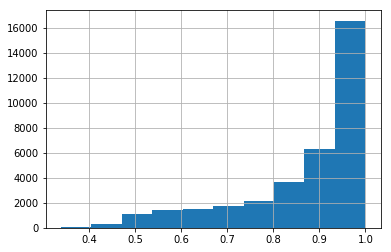

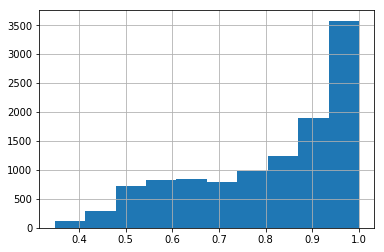

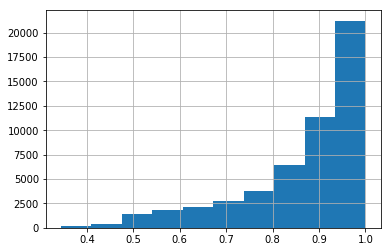

In [53]:
for l in [0, 1, 2]:
    pd_train[pd_train["label"] == l].confidence.hist()
    plt.show()

In [54]:
features_l1 = ["f_lin_words", "f_lin_chars", "f_lin_ngw", "f_lgbm_w2v", "f_lin_w2v",
               "f_log0", "f_log1", "f_log2"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B804CDD748>,
      dtype=object)

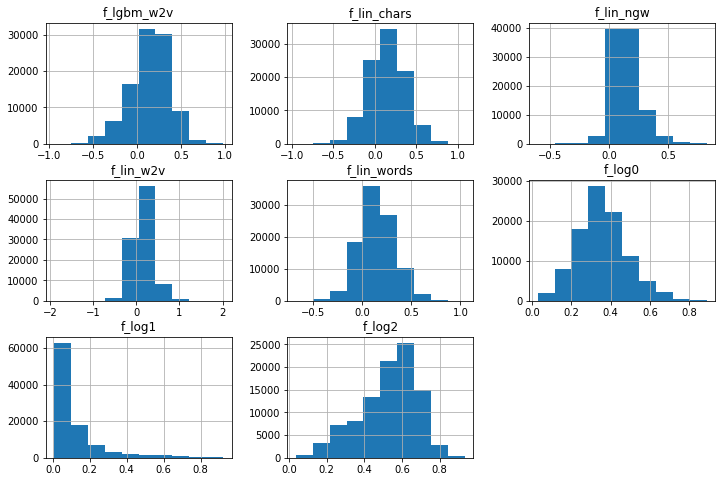

In [55]:
pd_train[features_l1].hist(figsize=(12,8))

# 2nd level

In [56]:
def to_feature_l2(df):
    def word_count(x):
        return len(re.findall(r"\b\w+\b", x))

    def char_count(x, target):
        return sum((1 for c in x if c == target))
 
    phrases = ["context_2", "context_1", "context_0", "reply"]
    return np.concatenate([df[features_l1].values, not_in_w2v(df), to_features_w2v_cos(df)] +
        [df[field].apply(word_count).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, '"')).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, ',')).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, '.')).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, '-')).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, '?')).values.reshape(-1, 1) for field in phrases] +
        [df[field].apply(lambda x: char_count(x, '!')).values.reshape(-1, 1) for field in phrases]
        , axis=1)

In [57]:
do_simple_cross_val(lightgbm.LGBMRegressor(), to_feature_l2, to_target_label_confidence)

A Jupyter Widget


0.6788334584035832 0.6807740823970534
86882.26505486405 87297.11996443273


In [58]:
do_simple_cross_val(lightgbm.LGBMRegressor(), to_feature_l2, to_target_label)

A Jupyter Widget


0.7875869974743234 0.791284292450915
86847.5790292042 87278.21811320301


# Submit

In [59]:
def do_submit_1l(target_col_name, model_reg, to_features, to_target, model_fit_params={}):
    i_train = pd_train
    i_test = pd_public

    X_train = to_features(i_train)
    X_test = to_features(i_test)
    Y_train = to_target(i_train)

    model_reg.fit(X_train, Y_train, **model_fit_params)
    Y_predict = model_reg.predict(X_test)

    pd_public.loc[:, target_col_name] = Y_predict

In [60]:
def do_submit_1l_cls(target_col_names, model_cls, to_features, to_target, model_fit_params={}):
    i_train = pd_train
    i_test = pd_public

    X_train = to_features(i_train)
    X_test = to_features(i_test)
    Y_train = to_target(i_train)

    model_cls.fit(X_train, Y_train, **model_fit_params)
    Y_predict = model_cls.predict_proba(X_test)

    pd_public.loc[:, target_col_names] = Y_predict

In [61]:
pd_public["f_lin_words"] = 0.0
do_submit_1l("f_lin_words", Ridge(alpha=20.0), to_features_words, to_target_label_confidence)

In [62]:
pd_public["f_lin_chars"] = 0.0
do_submit_1l("f_lin_chars", Ridge(alpha=20.0), to_features_chars, to_target_label_confidence)

In [63]:
pd_public["f_lin_ngw"] = 0.0
do_submit_1l("f_lin_ngw", Ridge(alpha=20.0), to_features_ngw, to_target_label_confidence)

In [64]:
pd_public["f_lgbm_w2v"] = 0.0
do_submit_1l("f_lgbm_w2v", lightgbm.LGBMRegressor(), to_features_w2v, to_target_label_confidence)

In [65]:
pd_public["f_lin_w2v"] = 0.0
do_submit_1l("f_lin_w2v", LinearRegression(), to_features_w2v, to_target_label_confidence)

In [66]:
pd_public["f_log0"] = 0.0
pd_public["f_log1"] = 0.0
pd_public["f_log2"] = 0.0
do_submit_1l_cls(["f_log0", "f_log1", "f_log2"],
            lightgbm.LGBMClassifier(), to_features_w2v, to_target_label)

In [67]:
model_reg = lightgbm.LGBMRegressor()

In [68]:
i_train = pd_train
i_test = pd_public.copy()

X_train = to_feature_l2(i_train)
X_test = to_feature_l2(i_test)
Y_train = to_target_label_confidence(i_train)

model_reg.fit(X_train, Y_train)
Y_predict = model_reg.predict(X_test)

In [69]:
i_test["predict"] = Y_predict
i_test.sort_values(["context_id", "predict"], ascending=[True, False], inplace=True)

In [70]:
i_test.head(15)

,context_id,context_2,context_1,context_0,reply_id,reply,f_lin_words,f_lin_chars,f_lin_ngw,f_lgbm_w2v,f_lin_w2v,f_log0,f_log1,f_log2,predict
37415,100006523969204,,"угадай , куда мы направляемся ?",куда ?,5,"в город , ведь ты всегда туда хотела .",0.580676,0.672737,0.214323,0.346976,0.481672,0.284732,0.014908,0.700360,0.603167
37411,100006523969204,,"угадай , куда мы направляемся ?",куда ?,1,на вокзал .,0.261248,0.203368,0.033066,0.148052,-0.025779,0.327724,0.068904,0.603372,0.553395
37413,100006523969204,,"угадай , куда мы направляемся ?",куда ?,3,подальше отсюда .,0.359158,0.349040,0.112601,0.245354,0.220058,0.339612,0.073593,0.586795,0.510178
37410,100006523969204,,"угадай , куда мы направляемся ?",куда ?,0,в музей .,0.254914,0.183122,0.033066,0.190548,-0.042190,0.409668,0.081864,0.508468,0.450425
37414,100006523969204,,"угадай , куда мы направляемся ?",куда ?,4,"сюда , ко мне .",0.275952,0.317865,0.077303,0.471924,0.135752,0.326007,0.057246,0.616747,0.389142
37412,100006523969204,,"угадай , куда мы направляемся ?",куда ?,2,на остров .,0.030953,0.132676,0.015018,-0.212567,-0.108940,0.458302,0.085510,0.456188,0.161807
37418,100033735295025,,я не ее подруга,"она сказала мне , что подруга .",2,это <CENSORED> . мы встречались пару раз,0.197311,0.058518,0.088441,0.266907,0.222003,0.308028,0.022031,0.669941,0.275428
37420,100033735295025,,я не ее подруга,"она сказала мне , что подруга .",4,она ничего не видела .,0.257617,0.292657,0.307659,0.204813,0.300854,0.361386,0.050364,0.588250,0.270243
37419,100033735295025,,я не ее подруга,"она сказала мне , что подруга .",3,"она . . она сказала , что сама все уладит .",0.292444,0.163782,0.209047,0.137468,0.381833,0.319363,0.011389,0.669248,0.231016
37417,100033735295025,,я не ее подруга,"она сказала мне , что подруга .",1,"вот именно , она не врала .",0.202484,0.180175,0.190327,0.251467,0.222744,0.360915,0.032727,0.606358,0.210343


In [71]:
submission_name = "final_stack_lgbm.tsv"

In [72]:
i_test[["context_id", "reply_id"]].to_csv(submission_name, index=False, header=False, sep="\t")